In [1]:
import sys
# from re import split
sys.path.append('../../../')
import os
# import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing

import ImpedanceCorrection as IC
%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
freqs, Z= preprocessing.readVersaStudio(f_name)

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


First, a simulated example with a somewhat representative circuit

In [31]:
print(10**-5)
np.log10(1e-5)

1e-05


-5.0

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Yes array
Capacitance that minimizes LY is:  0.0008235530295828552


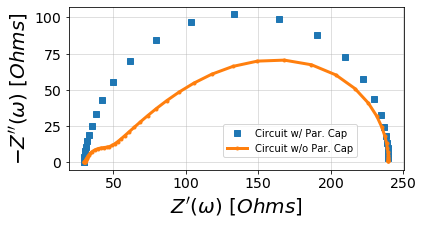

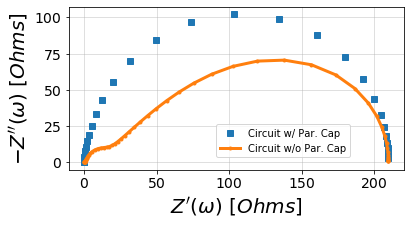

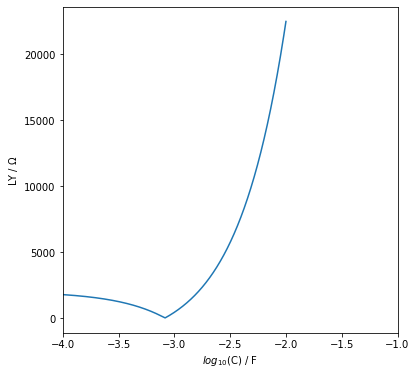

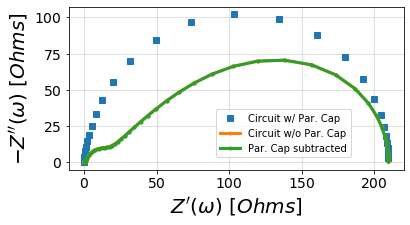

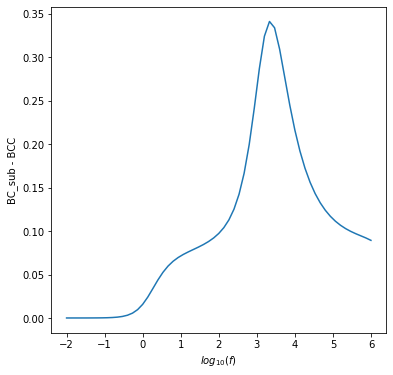

In [98]:
R_elyte = 30

circ = 'R1-p(E1,p(R2,C2)-G1)'
circCorr = 'R1-p(R2,C2)-G1)'

vals = [R_elyte, 8.233e-4, 1, 10, 1e-5, 200, .1]
valsCorr = [R_elyte, 10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

C_guess=np.logspace(-5,-2, num = 10000)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\OhmicCorrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')


BC_LY = IC.calcLY(C_guess, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plt.plot(np.log10(C_guess), BC_LY)
# ax0.set_ylim((0,10))
ax0.set_xlim((-4.001,-1))
ax0.set_ylabel('LY / $\Omega$')
ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Function.png', dpi=300, bbox_inches='tight')

C_sub = C_guess[np.argmin(BC_LY)]
print('Capacitance that minimizes LY is: ', C_sub)

BC_sub = IC.par_cap_subtract(C_sub, pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

Now, trying to use some real data from the July 2018 trip

Yes array
Capacitance that minimizes LY is:  1.4352107926607617e-06


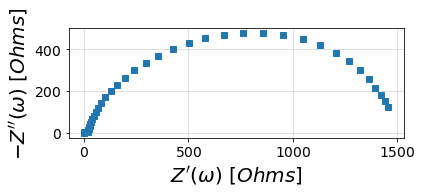

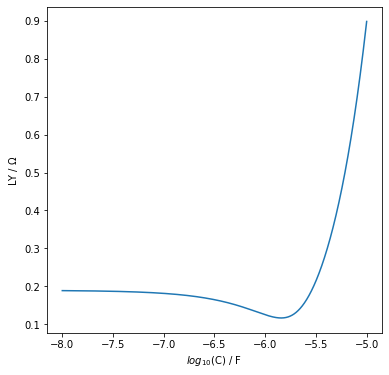

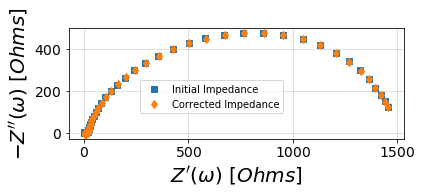

In [64]:
f0, Z0 = preprocessing.readVersaStudio(all_files[1])

f, Z = preprocessing.ignoreBelowX(f0, Z0)

Z = Z - Z[0]

#Just plotting data
fig=plt.figure(figsize = (6, 6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt='s')
# fig.savefig('Figures\Initial_RealData.png', dpi=300, bbox_inches = 'tight')

#Calculating and plotting LY
C_guess =np.logspace(-8,-5, num = 10000)
LY1=IC.calcLY(C_guess, f[1:], Z[1:])

fig = plt.figure(figsize = (6,6))
ax0 = fig.add_subplot(111)
plt.plot(np.log10(C_guess), LY1)
# ax0.set_ylim((0, 10))
# ax0.set_xlim((-4.001,-3))
ax0.set_ylabel('LY / $\Omega$')
ax0.set_xlabel('$log_{10}$(C) / F')
# fig.savefig('Figures\Correction_Fucntion_RealData.png', dpi=300, bbox_inches = 'tight')

C_sub = C_guess[np.argmin(LY1)]
print('Capacitance that minimizes LY is: ', C_sub)

Z_corr = IC.par_cap_subtract(C_sub, f[1:], Z[1:])
fig=plt.figure(figsize = (6, 6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
plot_nyquist(ax0, f, Z_corr, fmt = 'd')
fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

Doesn't work very well... Maybe we need to adjust the elements being removed with Berthier subtraction to include a resistor, too.

In [13]:
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import optimize

 active_mask: array([0.])
        cost: 0.32381287062620034
         fun: array([0.80475197])
        grad: array([43739.64908689])
         jac: array([[54351.71387726]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 30
        njev: 19
  optimality: 43739.64908688768
      status: 3
     success: True
           x: array([0.0008236])
 active_mask: array([0., 0.])
        cost: 0.31786770347216675
         fun: array([0.79733017])
        grad: array([77483.35330751,  2963.04806556])
         jac: array([[97178.50371052,  3716.21212999]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 24
        njev: 8
  optimality: 77483.35330751202
      status: 3
     success: True
           x: array([8.23638072e-04, 9.99997617e-01])


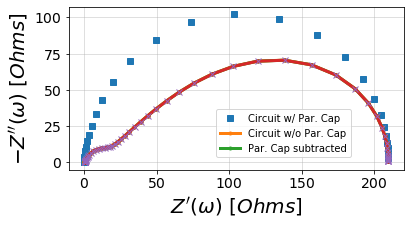

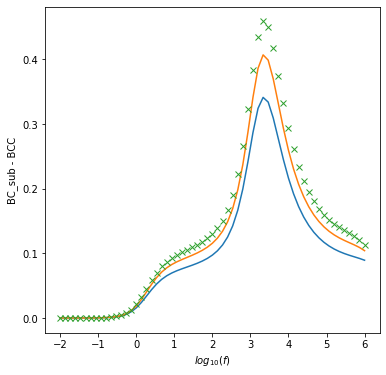

In [99]:
C0 = 1e-8
CPE0 = np.array([1e-8,1])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resCPE)

BC_sub2 = IC.par_cap_subtract(resC.x[0], pred_freq, BC_pred-R_elyte)
BC_sub3 = IC.par_cap_subtract(resCPE.x[0], pred_freq, BC_pred-R_elyte)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
plot_nyquist(ax0, pred_freq, BC_sub2)
plot_nyquist(ax0, pred_freq, BC_sub3,fmt='x')
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub2)-np.abs(BCC_pred-R_elyte))
plt.plot(np.log10(pred_freq), np.abs(BC_sub3)-np.abs(BCC_pred-R_elyte),'x')
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()

 active_mask: array([0.])
        cost: 0.0067752116381803165
         fun: array([0.11640629])
        grad: array([15.6120979])
         jac: array([[134.11731034]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 23
        njev: 6
  optimality: 15.612097902121194
      status: 3
     success: True
           x: array([1.4296875e-06])
 active_mask: array([0., 0.])
        cost: 0.005224987319285761
         fun: array([0.10222512])
        grad: array([ 0.08341542, -0.00432657])
         jac: array([[ 0.81599734, -0.0423239 ]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 22
        njev: 8
  optimality: 0.08341542352121399
      status: 3
     success: True
           x: array([5.35345674e-05, 7.30000008e-01])


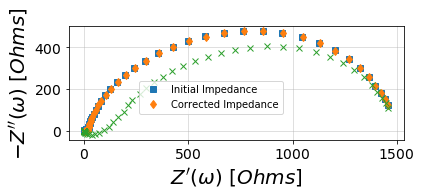

In [72]:
C0=1e-6
CPE0=np.array([1e-6,.73])

resC = least_squares(IC.Par_Cap_Res, C0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resC)

resCPE = least_squares(IC.Par_CPE_Res, CPE0, method= 'trf', args=(f[1:], Z[1:]), max_nfev=2000)
print(resCPE)

Z_corrC = IC.par_cap_subtract(resC.x[0], f[1:], Z[1:])
Z_corrCPE = IC.par_cap_subtract(resCPE.x[0], f[1:], Z[1:])

fig=plt.figure(figsize = (6, 6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, f, Z, fmt = 's')
plot_nyquist(ax0, f, Z_corrC, fmt = 'd')
plot_nyquist(ax0, f, Z_corrCPE, fmt = 'x')
fig.legend(labels = ('Initial Impedance', 'Corrected Impedance'), loc = 'center')
# fig.savefig('Figures\CorrectedZ_RealData.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
1 / resRC.x[0]

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
 active_mask: array([0., 0.])
        cost: 54.30773836353869
         fun: array([10.42187491])
        grad: array([       0.        , 25477560.10404154])
         jac: array([[      0.       , 2444623.4783864]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 16
        njev: 2
  optimality: 25477560.104041543
      status: 3
     success: True
           x: array([8.00000000e+03, 3.27835546e-04])


KeyError: 0

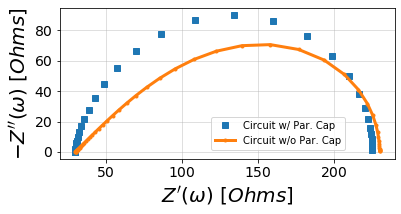

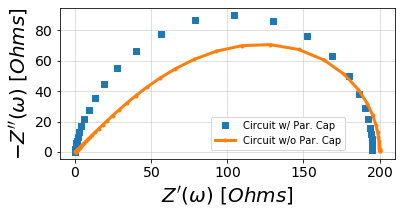

In [104]:
R_elyte = 30

circ = 'R1-p(C1,R3,G1)'
circCorr = 'R1-G1)'

vals = [R_elyte, 3.233e-4, 8000, 200, .1]
valsCorr = [R_elyte, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap'), loc=(0.525,0.3))
# fig.savefig('Figures\OhmicCorrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')


RC0 = np.array([8000, 1e-8])

resRC= least_squares(IC.Par_RC_Res, RC0, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
resRC= least_squares(IC.Par_RC_Res, resRC.x, method= 'trf', args=(pred_freq, BC_pred-R_elyte), max_nfev=2000)
print(resRC)

BC_sub = IC.par_RC_subtract(resRC, pred_freq, BC_pred-R_elyte)


fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred-R_elyte,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred-R_elyte)
plot_nyquist(ax0, pred_freq, BC_sub)
fig.legend(labels=('Circuit w/ Par. Cap', 'Circuit w/o Par. Cap', 'Par. Cap subtracted'), loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.plot(np.log10(pred_freq), np.abs(BC_sub)-np.abs(BCC_pred-R_elyte))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')
plt.show()